**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [1]:
# imports for the project

import pandas as pd

### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [2]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [3]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.1)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((12000, 2), (760, 2))

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



In [5]:
train_df.groupby('label').count()

,text
label,
Business,3000
Sci/Tech,3000
Sports,3000
World,3000


In [6]:
(   X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(9600,) (2400,) (9600,) (2400,)


In [7]:
cv = CountVectorizer()
X_train_vectorized = cv.fit_transform(X_train)

In [ ]:
lr_clf = LogisticRegression() # Note that we can set hyperparameters here

lr_clf.fit(X_train_vectorized, y_train)

LogisticRegression(C=0.005, max_iter=1000)

In [9]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

y_pred = lr_clf.predict(X_val_vectorized)

In [10]:
print("Performance on the training set:")
print(classification_report(y_train, lr_clf.predict(X_train_vectorized), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_pred, target_names=label_map.values()))


Performance on the training set:
              precision    recall  f1-score   support

       World       0.88      0.82      0.85      2388
      Sports       0.84      0.86      0.85      2376
    Business       0.89      0.96      0.92      2432
    Sci/Tech       0.89      0.86      0.88      2404

    accuracy                           0.87      9600
   macro avg       0.87      0.87      0.87      9600
weighted avg       0.88      0.87      0.87      9600

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.84      0.77      0.80       612
      Sports       0.80      0.81      0.80       624
    Business       0.85      0.94      0.89       568
    Sci/Tech       0.85      0.82      0.84       596

    accuracy                           0.83      2400
   macro avg       0.83      0.84      0.83      2400
weighted avg       0.83      0.83      0.83      2400



## Let's Improve the model with default features

- Ngram Range
- Stop words
- Max document Freaquecy
- Min document frequency
- Max features

In [11]:
(   X_train_imp,
    X_val_imp,
    y_train_imp,
    y_val_imp

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train_imp.shape, X_val_imp.shape, y_train_imp.shape, y_val_imp.shape)

(9600,) (2400,) (9600,) (2400,)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = LogisticRegression(max_iter=5000)

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
     ('tfidf', TfidfTransformer()),   
    ('classifier', clf)
])

# Define parameter grid for CountVectorizer
param_grid = {
    'vectorizer__ngram_range': [(1,2), (1,3)],  
    'vectorizer__stop_words': [None, 'english'],  
    'vectorizer__max_features': [1000, 10000], 
    'vectorizer__min_df': [5, 7, 8],  
    'vectorizer__max_df': [0.7, 0.8, 0.9],
    'classifier__penalty': ['l2', None],
    'classifier__C' : [0.01, 0.005, 0.001]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_imp, y_train_imp)  

# Evaluate on validation data
best_model = grid_search.best_estimator_ 
y_pred = best_model.predict(X_val_imp)  

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [14]:
best_model.get_params


<bound method Pipeline.get_params of Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, max_features=10000, min_df=5,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=5000, penalty=None))])>

In [15]:
X_train_vectorized = best_model.named_steps['vectorizer'].transform(X_train_imp)
X_val_vectorized = best_model.named_steps['vectorizer'].transform(X_val_imp)

# Make predictions
y_train_pred = best_model.named_steps['classifier'].predict(X_train_vectorized)
y_val_pred = best_model.named_steps['classifier'].predict(X_val_vectorized)

# Print classification report
print("Performance on the training set:")
print(classification_report(y_train_imp, y_train_pred, target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val_imp, y_val_pred, target_names=label_map.values()))

Performance on the training set:
              precision    recall  f1-score   support

       World       0.99      0.99      0.99      2388
      Sports       0.99      0.98      0.99      2376
    Business       0.98      1.00      0.99      2432
    Sci/Tech       0.99      0.98      0.99      2404

    accuracy                           0.99      9600
   macro avg       0.99      0.99      0.99      9600
weighted avg       0.99      0.99      0.99      9600

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.82      0.83      0.83       612
      Sports       0.85      0.80      0.82       624
    Business       0.88      0.95      0.91       568
    Sci/Tech       0.88      0.85      0.86       596

    accuracy                           0.85      2400
   macro avg       0.86      0.86      0.86      2400
weighted avg       0.85      0.85      0.85      2400



## Improving the model with lemmatization, normalization, stop words

In [33]:
(   X_train_2,
    X_val_2,
    y_train_2,
    y_val_2

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train_2.shape, X_val_2.shape, y_train_2.shape, y_val_2.shape)

(9600,) (2400,) (9600,) (2400,)


In [34]:
import spacy
import nltk
from nltk.stem import PorterStemmer
nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')
stemmer = PorterStemmer()

nltk.data.path.append(r'C:\Users\User\AppData\Roaming\nltk_data')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:

def spacy_lemmatizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

def stemming_tokenizer(text):
    return [stemmer.stem(word) for word in nltk.word_tokenize(text) if word.isalpha()]


In [37]:
cv2 = CountVectorizer(max_df=0.7, max_features=1000, min_df=1,
                                 ngram_range=(1, 3), stop_words='english', tokenizer=spacy_lemmatizer)
X_train_vectorized_2 = cv2.fit_transform(X_train_2)

tfidf_transformer = TfidfTransformer()
X_train_tfidf_2 = tfidf_transformer.fit_transform(X_train_vectorized_2)

lr_clf_2 = LogisticRegression(penalty='l2', C=0.01) 

lr_clf_2.fit(X_train_vectorized_2, y_train_2)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(


LogisticRegression(C=0.01)

In [38]:
X_val_vectorized_2 = cv2.transform(X_val_2) # note that we use transform here, not fit_transform

y_pred_2 = lr_clf_2.predict(X_val_vectorized_2)

In [39]:
print("Performance on the training set:")
print(classification_report(y_train_2, lr_clf_2.predict(X_train_vectorized_2), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val_2, y_pred_2, target_names=label_map.values()))

Performance on the training set:
              precision    recall  f1-score   support

       World       0.86      0.82      0.84      2388
      Sports       0.83      0.84      0.84      2376
    Business       0.89      0.95      0.92      2432
    Sci/Tech       0.89      0.86      0.88      2404

    accuracy                           0.87      9600
   macro avg       0.87      0.87      0.87      9600
weighted avg       0.87      0.87      0.87      9600

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.86      0.78      0.82       612
      Sports       0.80      0.82      0.81       624
    Business       0.84      0.95      0.89       568
    Sci/Tech       0.89      0.83      0.86       596

    accuracy                           0.84      2400
   macro avg       0.85      0.85      0.84      2400
weighted avg       0.85      0.84      0.84      2400



### Important Parameters

When optimizing our model, we found that increasing the size of the training dataset to 10% led to a huge improvement in our performance
Other hyperparameters that improved our model:
- lemmatization -> We tried using lemmatization to use word roots as tokens, but it didn't improve performace
- Normalization witf TfIdf -> Looks like normalization didn't help to improve the performance on the test set
- max_df, min_df 
- stop_words -> Stop words are imporving performance, not taking ht emost used and most common words into consideration
- In logsitic regression: l2 regularization and C to avoid overfitting


With the following parameters

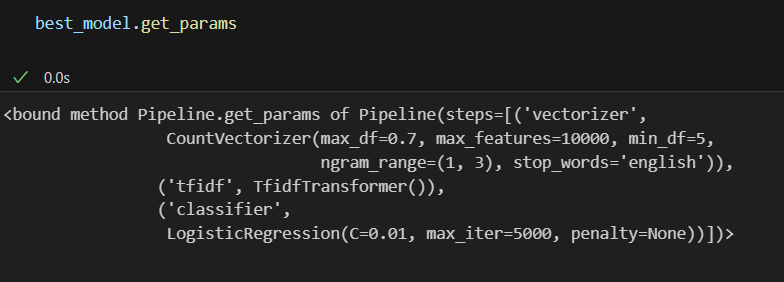

We managed to get the folllowing results:

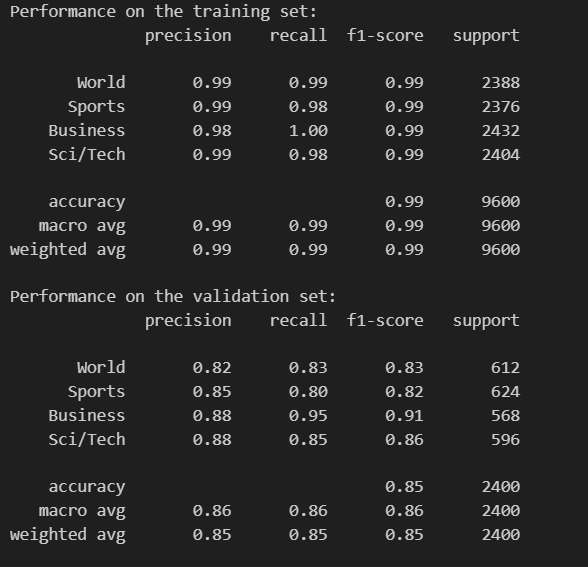
